**Part 1:** 

Use the **Fashion-MNIST** dataset for this question.

1a) Load the dataset and implement the K Means algorithm. You need to find the optimal number of clusters using the
> i) elbow method

> ii) silhoette method



1b) Define the initial clusters’ centroids using:</br>
> i) Forgy</br>

> ii) Random Partition

1c) Experiment with different distance measures [Euclidean distance, Manhattan distance].

1d) Plot the error vs number of clusters graph while using the elbow method and silhouette 
    method. Report the optimal number of clusters found.


1e) Visualize the dataset to depict the clusters formed. (prefer T-SNE)

</br>
</br>
</br>
</br>


**Part 2:**
</br>
In this task, you need to implement Hierarchical clustering (agglomerative) on the same dataset.

2a) visualize a dendogram and find out the optimal number of clusters with the help of Dendogram. Explain the procedure.


2b) Implement Hierarchical clustering using: </br>
> i) single linkage

> ii) Complete linkage

>Visualize the clusters obtained using these linkages and compare. 



In [1]:
# importing all libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [2]:
#implement elbow method from scratch
def elbow(X, K, metric='euclidean', init_centroid_method='forgy'):
  distortions = []
  for k in range(1,K+1):
    model = Kmeans(k,metric=metric,init_centroid_method=init_centroid_method)
    model.fit(X)

    sum=0
    for i in range(k):
      cluster = model.classification[i]
      centroid = np.average(cluster,axis=0)
      for j in cluster:
        dist=np.linalg.norm(j-centroid)
        sum+=dist
    
    distortions.append(sum/X.shape[0])
    print(f'{k} : {sum/X.shape[0]}')

  # graph
  plt.plot(range(1,K+1), distortions, 'bx-')
  plt.xlabel('K value')
  plt.ylabel('Distortion')
  plt.title('Elbow Method using Distortion')
  plt.show()

In [3]:
#implement silhouette method from scratch
from collections import Counter
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import distance_metrics
from itertools import combinations

def silhouette(X, K, metric='euclidean', init_centroid_method='forgy'):
  
  def Intra_cluster(X, labels):
    intra_dist = np.zeros(labels.size, dtype=float)
    for label in np.unique(labels):
        subX = X[np.where(labels == label)[0]]                    # finding the clusters
        distances = pairwise_distances(subX, metric="euclidean")  # all pair distances in each cluster
        avg = distances.sum(axis=1) / (distances.shape[0] - 1)   # taking tha average of it
        intra_dist[np.where(labels == label)[0]] = avg           # filling the array
    return intra_dist
  
  def Inter_cluster(X, labels):
      inter_dist = np.empty(labels.size, dtype=float)
      inter_dist.fill(np.inf)
      unique_labels = np.unique(labels)
      for label1, label2 in combinations(unique_labels, 2):
          SubX = X[np.where(labels == label1)[0]]
          SubY = X[np.where(labels == label2)[0]]

          dist = pairwise_distances(SubX, SubY, metric="euclidean")
          dist_a = dist.mean(axis=1)
          dist_b = dist.mean(axis=0)
          
          indices_a = np.where(labels == label1)[0]
          inter_dist[indices_a] = np.minimum(dist_a, inter_dist[indices_a])
          indices_b = np.where(labels == label2)[0]
          inter_dist[indices_b] = np.minimum(dist_b, inter_dist[indices_b])
      return inter_dist

  score=[]
  map={}
  for i in range(2,K+1):
    model = Kmeans(i,metric=metric,init_centroid_method=init_centroid_method)
    model.fit(X)
    labels = model.labels
    inter_cluster=Inter_cluster(X,labels)
    intra_cluster=Intra_cluster(X,labels)
    avg=np.nan_to_num((inter_cluster-intra_cluster)/np.maximum(inter_cluster,intra_cluster))

    score.append(np.mean(avg))

    print(f'{i} : {np.mean(avg)}')


  plt.plot(range(2,K+1), score, 'bx-')
  plt.xlabel('K value')
  plt.ylabel('Score')
  plt.title('Silhouette Score')
  plt.show()

In [4]:
#implement Kmeans from scratch
class Kmeans:

  def __init__(self, k=3, tol=0.001, iter=100, metric='manhattan', init_centroid_method='forgy'):
    self.k = k
    self.tol = tol
    self.iter = iter
    self.centroids = {} # dict or map
    self.classification = {}  # pts in that cluster
    self.labels = [] # cluster index of point
    
    self.metric = metric
    self.init_centroid_method = init_centroid_method

  # forgy & random_partition
  def init_centroids(self, X, method='forgy'):
    if method == 'random_partition':
      indices = np.random.choice(range(0, self.k), replace = True, size = X.shape[0])
      mean = []
      for count in range(self.k):
        mean.append(X[indices == count].mean(axis=0))
      return np.concatenate([val[ None, :] for val in mean], axis = 0)

    else:
      return X[np.random.choice(range(X.shape[0]), replace = False, size = self.k), :]

  # euclidean and manhattan
  def calc_dist(self, a, b, metric='euclidean'):
    if metric == 'euclidean':
      return np.linalg.norm(a-b)
    elif metric == 'manhattan':
      return np.abs(a - b).sum()

  def fit(self, data):
    self.labels = np.zeros(len(data))

    # init centroids
    # for i in range(self.k):
    #   self.centroids[i] = data[i]
    temp = self.init_centroids(data,self.init_centroid_method)
    for i in range(self.k):
      self.centroids[i] = temp[i]
    
    for it in range(self.iter):
      self.classification = {}
      
      for i in range(self.k):
        self.classification[i] = []

      for i in range(len(data)):
        row = data[i]
        distances = [self.calc_dist(row, self.centroids[i], self.metric) for i in self.centroids] # centroids is map so, iterator iterates over key (index)
        classification = distances.index(min(distances))
        self.classification[classification].append(row)
        self.labels[i] = classification

      # prev_centroids = dict(self.centroids)
      for c in self.classification:
        self.centroids[c] = np.average(self.classification[c],axis=0)

      # optimized = True
      # for c in self.centroids:
      #   original_centroid = prev_centroids[c]
      #   current_centroid = self.centroids[c]
      #   if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
      #       optimized = False
      # if optimized:
      #   break
  

In [5]:
from keras.datasets import fashion_mnist
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

# you can performs your training on train/test dataset alone if there are computational issues

# Reshape 3D to 2D, each 28x28 image pixels into 1D array
X = testX.reshape(-1,testX.shape[1]*testX.shape[2]) 
X.shape

4431872/4422102 [==============================] - 0s 0us/step


(10000, 784)

1 : 2064.6759348680957
2 : 1826.3496868729935
3 : 1693.714490525071
4 : 1613.0397801001498
5 : 1568.3640000622195
6 : 1541.4599400265868
7 : 1516.502341877789
8 : 1490.291836175994
9 : 1441.3269288627503
10 : 1427.1154411100629


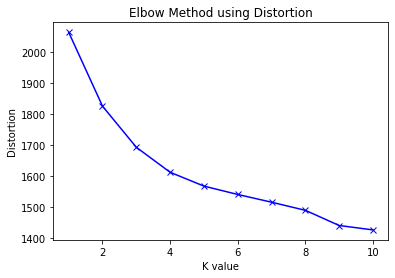

In [ ]:
elbow(X,10,metric='manhattan',init_centroid_method='forgy')

1 : 2064.6759348680957
2 : 1825.4888440865625
3 : 1686.789497987609
4 : 1608.2601117955112
5 : 1578.2207416087258
6 : 1525.0671744764834
7 : 1473.3070006081264
8 : 1445.019207846574
9 : 1421.5898528962455
10 : 1400.2156010651752


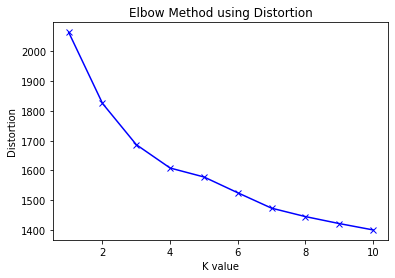

In [6]:
elbow(X,10,metric='euclidean',init_centroid_method='random_partition')

2 : 0.19885013908655458
3 : 0.19190010409755723
4 : 0.17087008653630628
5 : 0.15083648489995313
6 : 0.15894989745273114
7 : 0.1631575544211337
8 : 0.1515301740018525
9 : 0.1599994862636803
10 : 0.13317032043899296


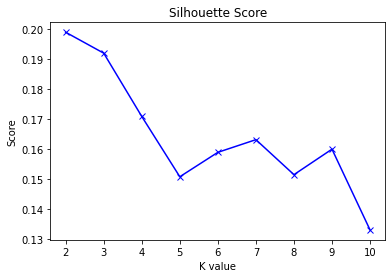

In [ ]:
# silhouette on smaller data due to time
test_data = X[:500]

# silhouette score
silhouette(test_data, 10, metric='euclidean', init_centroid_method='forgy')

- Elbow: 
After running elbow on different parameters, it seems that 5 and 8 are optimal in elbow.
- Silhouette: It is run on 500 rows (X[0:500]), so not really a useful output. We can say that at 9 it is showing significant increase in score and after testing over whole train data, it can show promising results.


In [7]:
# t-distributed Stochastic Neighbor Embedding (t-SNE) visualization
from sklearn.manifold import TSNE

def perform_tsne(x_test, labels, title):
	tsne = TSNE(n_components=2, random_state=0)
	x_test_2d = tsne.fit_transform(x_test)

	color_map = {0:'red', 1:'blue', 2:'lightgreen', 3:'purple', 4:'cyan', 5:'lightseagreen', 6:'blueviolet', 7:'magenta', 8:'pink', 9:'yellow', 10:'gray'}
	plt.figure()
	for idx, cl in enumerate(np.unique(labels)):
	  plt.scatter(x=x_test_2d[labels==cl,0], y=x_test_2d[labels==cl,1], c=color_map[idx], marker='o', label=cl)
	plt.xlabel('X in t-SNE')
	plt.ylabel('Y in t-SNE')
	plt.legend(loc='upper left')
	plt.title('t-SNE visualization for ' + title)
	plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


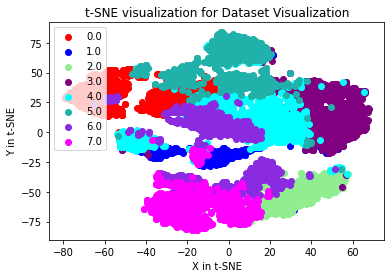

In [8]:
model = Kmeans(8,metric='euclidean',init_centroid_method='forgy')
model.fit(X)

perform_tsne(X,model.labels,'Dataset Visualization')

Hierarchical clustering

In [9]:
# implement hierarchical clustering ( you can use scikit module)
def hierarchical_clustering(X,k,linkage='single'):
  model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
  model.fit(X)
  labels = model.labels_
  return model

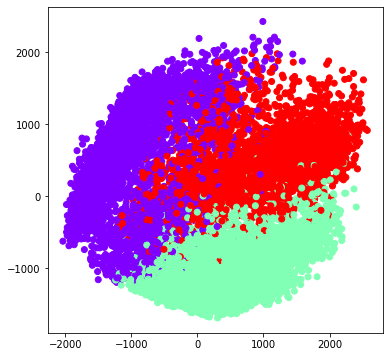

In [ ]:
from sklearn.decomposition import PCA
ac3 = AgglomerativeClustering(n_clusters = 3)
labels = ac3.fit_predict(X)

pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

plt.figure(figsize =(6, 6))
plt.scatter(X_principal['P1'], X_principal['P2'], c = labels, cmap ='rainbow')
plt.show()

In [ ]:
#visualize a dendogram

def dendogram(X, method='ward'):
  dendrogram = sch.dendrogram(sch.linkage(X, method=method))

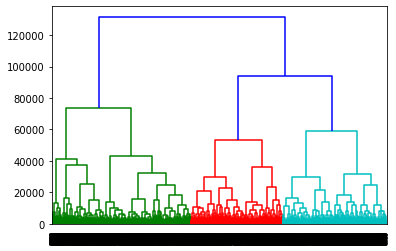

In [ ]:
# ward linkage
dendogram(X)

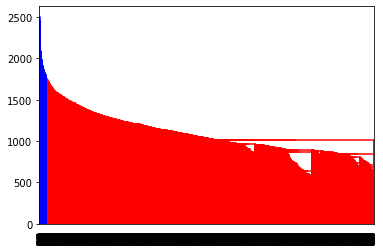

In [ ]:
import sys
sys.setrecursionlimit(10**8)
# single linkage
dendogram(X,'single')

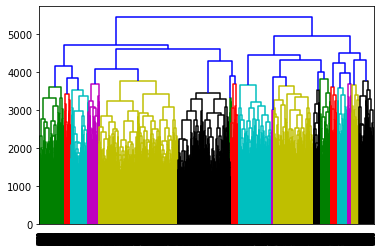

In [ ]:
# complete linkage
dendogram(X,'complete')

**Question**: Explain the procedure to find the optimal number of clusters using dendogram

Answer: 
1. Find the largest vertical distance that doesn't intersect any of the other clusters.
2. Draw horizontal line at both extremities.
3. Optimal no. of clusters will be equal to no. of vertical lines going through the horizontal line.





/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


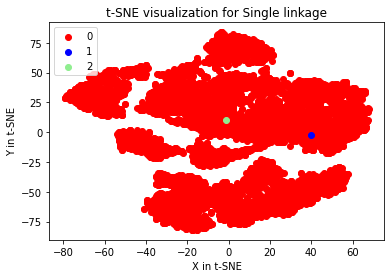

In [ ]:
model = hierarchical_clustering(X,3,'single')
perform_tsne(X,model.labels_, 'Single linkage')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


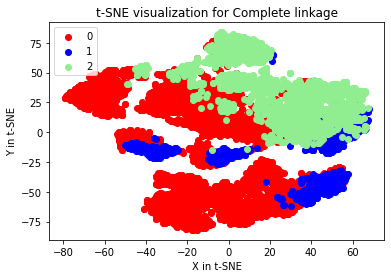

In [ ]:
model = hierarchical_clustering(X,3,'complete')
perform_tsne(X,model.labels_, 'Complete linkage')

**Question:** Mention the differences observed using single and complete linkage:

Answer:

The visualization in complete linkage is better than in single linkage, in single all the points are almost in one class, while that is not case with complete linkage.